# **Objective:**
**To develop a machine learning model capable of accurately forecasting hourly energy consumption for the PJM Interconnection region. This model aims to help in understanding demand patterns, managing energy resources more efficiently, and planning for future energy needs.**

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [4]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


PJME_MW    0
dtype: int64


In [7]:
# Get a statistical summary of the dataset
statistical_summary = df.describe()
print(statistical_summary)


             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


**Plot the Overall Energy Consumption Over Time**

Visualizing the energy consumption over time will help identify any apparent trends, seasonality, or outliers.

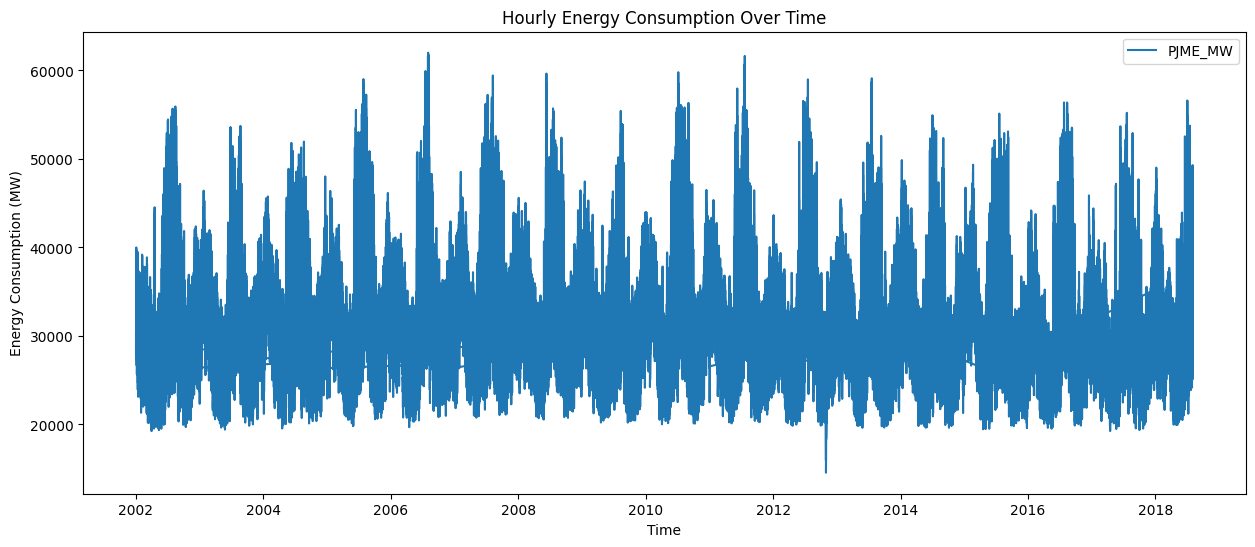

In [16]:
import matplotlib.pyplot as plt

# Plotting the energy consumption over time
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['PJME_MW'], label='PJME_MW')
plt.title('Hourly Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()


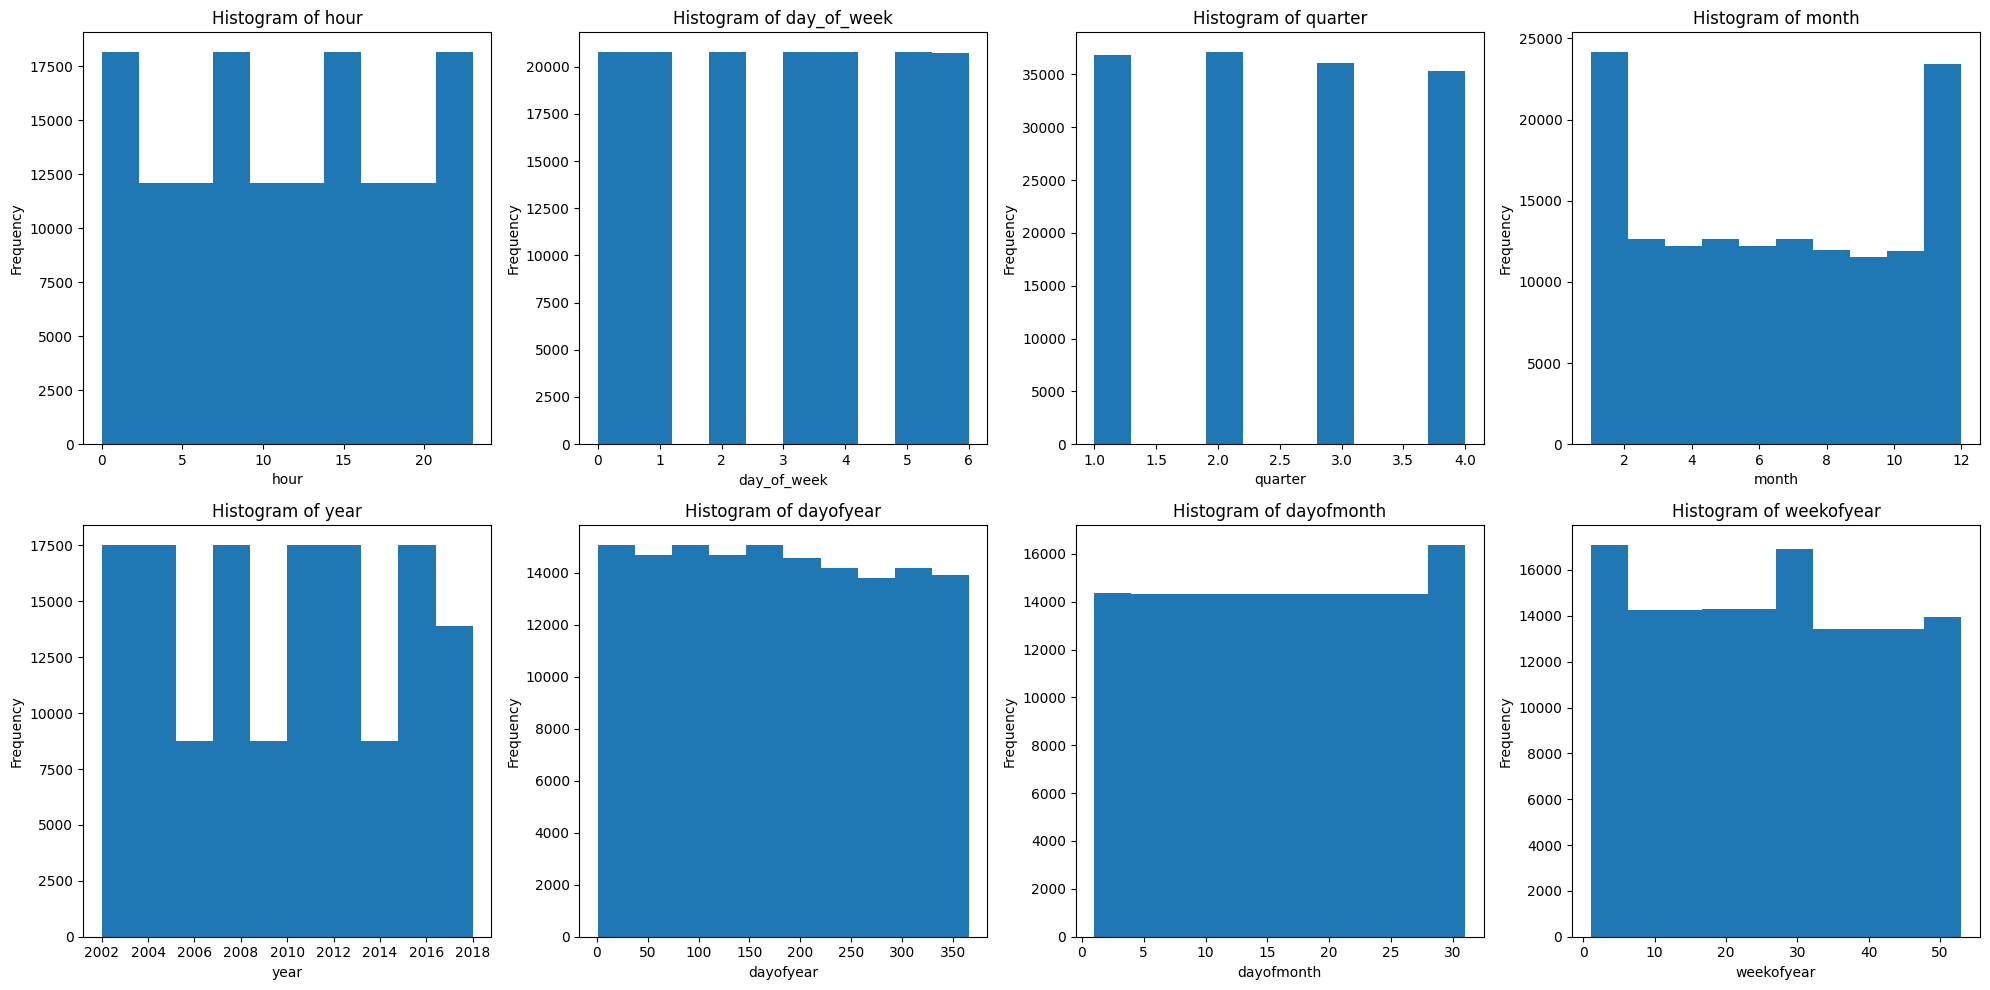

In [10]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplots
rows = 2
cols = 4

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

# Iterate through features and create subplots
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
index = 0
for i in range(rows):
    for j in range(cols):
        if index >= len(features):
            break
        feature = features[index]
        axes[i, j].hist(df[feature])
        axes[i, j].set_xlabel(feature)
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_title(f'Histogram of {feature}')
        index += 1

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()


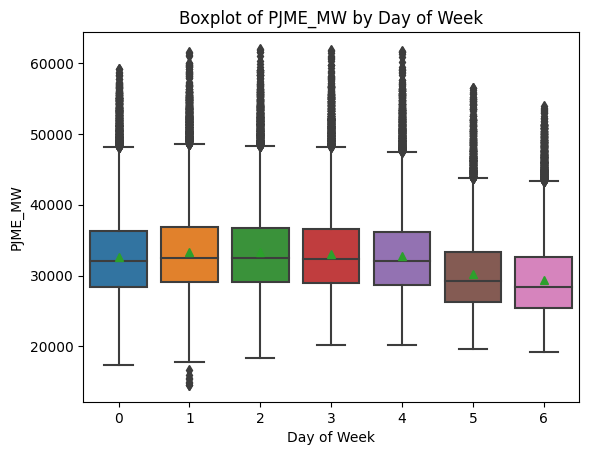

In [11]:
import seaborn as sns

# Create box plots for numerical features
sns.boxplot(
    x = "day_of_week",
    y = "PJME_MW",
    showmeans=True,
    data=df
)
plt.xlabel('Day of Week')
plt.ylabel('PJME_MW')
plt.title('Boxplot of PJME_MW by Day of Week')
plt.show()

# You can create similar boxplots for other features like month, quarter, etc.


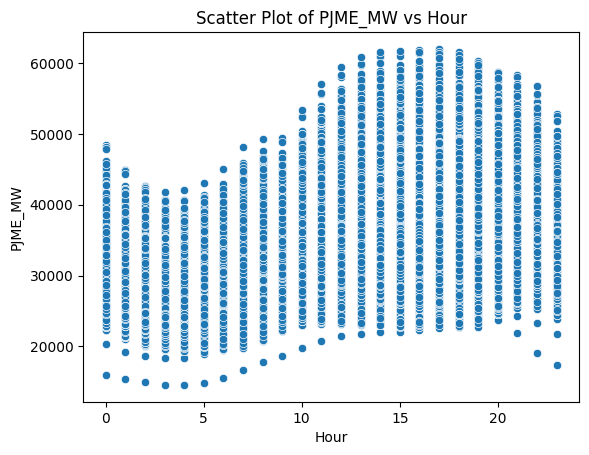

In [12]:
# Create scatter plots between numerical features and PJME_MW
sns.scatterplot(
    x = "hour",
    y = "PJME_MW",
    data=df
)
plt.xlabel('Hour')
plt.ylabel('PJME_MW')
plt.title('Scatter Plot of PJME_MW vs Hour')
plt.show()

# You can create similar scatterplots for other features like day_of_week, month, etc.


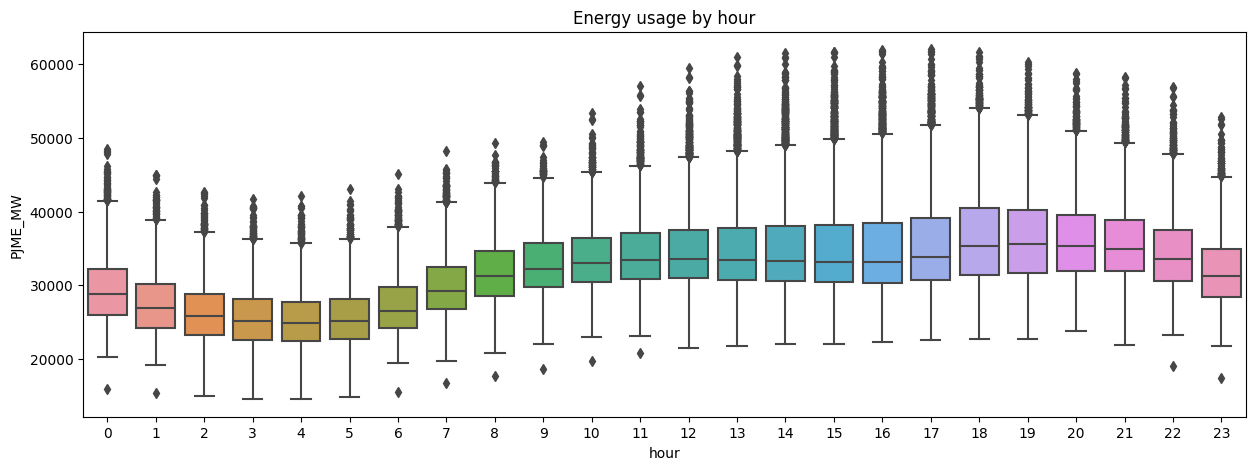

In [13]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='hour',y='PJME_MW')
plt.title('Energy usage by hour')
plt.show()

In [15]:
mean_MW = df['PJME_MW'].mean()
std_MW = df['PJME_MW'].std()
threshold = 3

df['Z_score'] = (df['PJME_MW'] - mean_MW) / std_MW

outliers = df[(df['Z_score'] > threshold) | (df['Z_score'] < -threshold)]

print("Outliers:")
outliers


Outliers:


,PJME_MW,hour,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,Z_score
Datetime,,,,,,,,,,
2002-08-19 14:00:00,52145.0,14,0,3,8,2002,231,19,34,3.104075
2002-08-19 15:00:00,53094.0,15,0,3,8,2002,231,19,34,3.250888
2002-08-19 16:00:00,53575.0,16,0,3,8,2002,231,19,34,3.325300
2002-08-19 17:00:00,53739.0,17,0,3,8,2002,231,19,34,3.350671
2002-08-19 18:00:00,53202.0,18,0,3,8,2002,231,19,34,3.267596
...,...,...,...,...,...,...,...,...,...,...
2018-07-01 18:00:00,51803.0,18,6,3,7,2018,182,1,26,3.051166
2018-06-18 16:00:00,51818.0,16,0,2,6,2018,169,18,25,3.053487
2018-06-18 17:00:00,52558.0,17,0,2,6,2018,169,18,25,3.167967


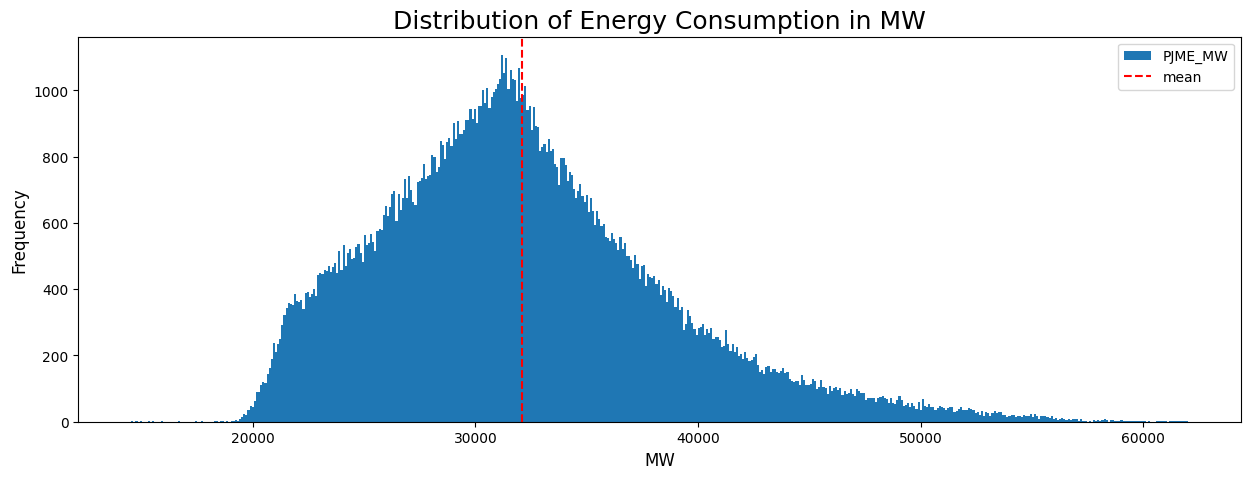

In [22]:
df['PJME_MW'].plot(figsize=(15, 5), kind='hist', bins=500)


plt.title('Distribution of Energy Consumption in MW', fontsize=18)
plt.xlabel('MW', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.axvline(x=mean_MW, color='r', linestyle='--', label='mean')

plt.legend()

plt.show()


In [28]:
def create_features(df):
    """
    Create time series features based on the time series index. 
    """

    df = df.copy()
    
    df['Hour'] = df.index.hour
    df['Day_of_Week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day_of_Year'] = df.index.dayofyear
    df['Day_of_Month'] = df.index.day
    df['Week_of_Year'] = df.index.isocalendar().week
    
    return df

df = create_features(df)


In [62]:
from sklearn.model_selection import train_test_split

FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year', 'Day_of_Year', 'Day_of_Month', 'Week_of_Year']
TARGET = 'PJME_MW'

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 116292
Testing set size: 29074


In [37]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32426.86483	validation_1-rmse:32315.85197


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:42:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12545.41083	validation_1-rmse:12483.53736
[200]	validation_0-rmse:5873.94051	validation_1-rmse:5839.14622
[300]	validation_0-rmse:4007.98957	validation_1-rmse:3986.61144
[400]	validation_0-rmse:3546.45907	validation_1-rmse:3531.74739
[500]	validation_0-rmse:3395.68397	validation_1-rmse:3386.57628
[600]	validation_0-rmse:3318.54026	validation_1-rmse:3311.63510
[700]	validation_0-rmse:3264.57434	validation_1-rmse:3258.08814
[800]	validation_0-rmse:3228.10899	validation_1-rmse:3222.21826
[900]	validation_0-rmse:3195.11390	validation_1-rmse:3190.44718
[999]	validation_0-rmse:3172.99343	validation_1-rmse:3168.64748


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

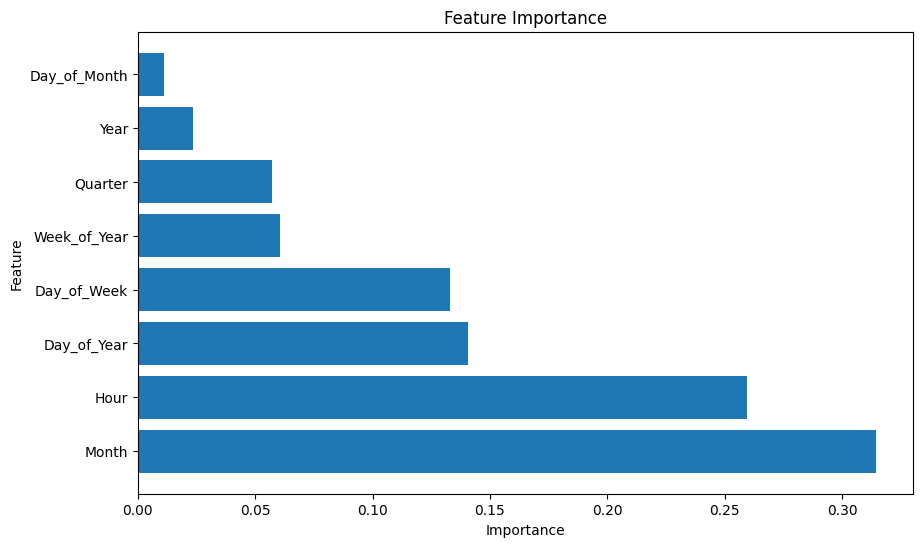

In [40]:
feature_importance = reg.feature_importances_

fi_df = pd.DataFrame({'Feature': FEATURES, 'Importance': feature_importance})

fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [47]:
y_pred = reg.predict(X_test)

predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

print(predictions_df)

                      Actual     Predicted
Datetime                                  
2017-01-21 08:00:00  27569.0  31493.560547
2008-05-20 20:00:00  31919.0  33848.687500
2011-12-22 06:00:00  25888.0  29086.689453
2003-01-23 23:00:00  40771.0  34502.281250
2004-01-03 02:00:00  24128.0  29245.369141
...                      ...           ...
2004-10-12 19:00:00  32232.0  33816.328125
2016-05-11 18:00:00  29259.0  31194.275391
2015-03-29 05:00:00  29222.0  22175.830078
2005-09-10 07:00:00  25286.0  27660.574219
2005-09-26 14:00:00  39120.0  34521.906250

[29074 rows x 2 columns]


In [48]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("\nMean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 10040326.833872214
Mean Absolute Error (MAE): 2349.4563334750337
Root Mean Squared Error (RMSE): 3168.647477058976
R-squared (R2): 0.7565046118588958


In [50]:
absolute_errors = np.abs(y_pred - y_test)

predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Absolute_Error': absolute_errors})

worst_predictions = predictions_df.sort_values(by='Absolute_Error', ascending=False)

print("Worst Predictions:")
print(worst_predictions.head())

best_predictions = predictions_df.sort_values(by='Absolute_Error', ascending=True)

print("\nBest Predictions:")
print(best_predictions.head())


Worst Predictions:
                      Actual     Predicted  Absolute_Error
Datetime                                                  
2008-06-10 16:00:00  59445.0  40285.125000    19159.875000
2011-06-09 16:00:00  57969.0  39349.292969    18619.707031
2008-06-10 15:00:00  58785.0  40190.136719    18594.863281
2008-06-09 16:00:00  58278.0  40150.289062    18127.710938
2008-06-09 18:00:00  58310.0  40770.234375    17539.765625

Best Predictions:
                      Actual     Predicted  Absolute_Error
Datetime                                                  
2016-12-25 07:00:00  26682.0  26681.695312        0.304688
2016-11-13 19:00:00  29890.0  29889.652344        0.347656
2004-09-03 01:00:00  28276.0  28275.457031        0.542969
2015-11-26 06:00:00  25315.0  25315.707031        0.707031
2012-10-02 08:00:00  29587.0  29588.044922        1.044922


In [63]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_df['Absolute_Error'] = np.abs(predictions_df['Actual'] - predictions_df['Predicted'])
predictions_df['Month'] = X_test['Month'] 

mean_absolute_error_by_month = predictions_df.groupby('Month')['Absolute_Error'].mean()

worst_predicted_month = mean_absolute_error_by_month.idxmax()
best_predicted_month = mean_absolute_error_by_month.idxmin()

print("Worst Predicted Month:", worst_predicted_month)
print("Best Predicted Month:", best_predicted_month)


Worst Predicted Month: 7
Best Predicted Month: 10
